In [90]:
### Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import Image

DATA_DIR = './data'

In [91]:
#### Removal of activities with a duration of 0 seconds
activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))
math_results = pd.read_csv('{}/original/math_results.csv'.format(DATA_DIR))
math_questions = pd.read_csv('{}/original/math_questions.csv'.format(DATA_DIR))
all_scores = pd.read_csv('{}/original/all_scores.csv'.format(DATA_DIR))
math_questions = pd.read_csv('{}/original/math_questions.csv'.format(DATA_DIR))

In [109]:
math_questions

,Unnamed: 0,question_id,test_id,content,tip_enabled,points
0,0,1,2,"<span class=""token function selector"">[latex] ...",0,1
1,1,2,2,[latex] 9600 + $$\bigbox$$ = 24000 ? [/latex],0,1
2,2,3,2,[latex] 9600 + \Box = 24000 [/latex],0,1
3,3,4,2,[latex] 9600 + ? = 24000 [/latex],0,1
4,4,5,0,NaN,0,1
...,...,...,...,...,...,...
1047,18,1048,41,"<p><img class=""alignnone size-large wp-image-1...",0,0
1048,19,1049,40,"<p class=""p1"">Das Becken ist voll. Alle Zuleit...",0,0
1049,20,1050,40,"<p class=""p1"">In der untenstehenden Graphik is...",0,0
1050,21,1051,44,Herr Rieser verbringt seine Ferien in den USA....,1,1


In [92]:
math_results.rename(columns={'exam_id':'test_id'}, inplace=True)

In [93]:
all_scores = all_scores.drop_duplicates(subset=['user_id','test_id'], keep='first')
all_scores[all_scores['course'].isin([42, 3865])]

,Unnamed: 0,user_id,test_id,course,percentage,time
0,0,2533,12,42,14.29,1680888414
1,1,2533,20,42,55.56,1680891690
2,13,2533,21,42,10.00,1690277709
3,14,2533,17,42,30.00,1690363112
4,15,2533,51,3865,0.00,1692109289
...,...,...,...,...,...,...
3810,3828,956,48,3865,75.00,1741162134
3811,3829,923,37,42,90.00,1741181002
3812,3830,127,15,42,83.33,1741192125
3813,3831,922,33,42,0.00,1741198071


In [94]:
# 1) Ensure math_results.time is datetime
# 1) Ensure math_results.time is datetime
math_results['time'] = pd.to_datetime(math_results['time'],unit='s')

# 2) Aggregate per user/test (first attempt only)
#    Sort so that first attempt is earliest
exam_agg = (
    math_results
    .sort_values('time')
    .groupby(['user_id','test_id','course_id'], as_index=False)
    .agg(
        time         = ('time', 'first'),
        points_sum   = ('points',      'sum'),
        max_sum      = ('max_points',  'sum')
    )
)

# 3) Keep only the first exam attempt (drop any retakes)
exam_agg = exam_agg.drop_duplicates(subset=['user_id','test_id'], keep='first')

# 4) Compute percentage
exam_agg['percentage'] = exam_agg['points_sum'] / exam_agg['max_sum'] * 100

# 5) Compute performance as deviation from test-wide mean
exam_agg['performance'] = (
        exam_agg['percentage']
        - exam_agg.groupby('test_id')['percentage'].transform('mean')
)

# 6) Final touches: rename and add domain/date
exam_agg = exam_agg.rename(columns={
    'course_id': 'course'
})
exam_agg['domain'] = 'math'
exam_agg['date']   = exam_agg['time'].dt.normalize()

# 7) Select and reorder columns
performances_math = exam_agg[[
    'user_id','domain','test_id','course',
    'date','time','percentage','performance'
]]

In [95]:
activity.dropna(inplace=True)

In [96]:
performances_math

,user_id,domain,test_id,course,date,time,percentage,performance
0,1,math,66,3865,2025-02-20,2025-02-20 12:04:33,0.000000,0.000000
1,6,math,42,3865,2024-11-23,2024-11-23 10:25:34,45.833333,-17.828526
2,6,math,48,3865,2025-01-08,2025-01-08 14:48:04,50.000000,-5.442146
3,6,math,49,3865,2025-01-08,2025-01-08 15:29:07,66.666667,18.583496
4,6,math,50,3865,2025-02-04,2025-02-04 15:36:38,54.545455,14.304334
...,...,...,...,...,...,...,...,...
4459,4095,math,49,3865,2024-10-18,2024-10-18 15:41:47,0.000000,-48.083171
4460,4095,math,50,3865,2024-10-18,2024-10-18 15:49:00,0.000000,-40.241121
4461,4095,math,51,3865,2024-09-24,2024-09-24 16:00:51,20.000000,-23.154761
4462,4095,math,53,3865,2024-09-24,2024-09-24 16:07:01,0.000000,-59.587641


In [97]:
performances[performances['domain'] == 'math']

,user_id,domain,test_id,course,date,time,percentage,performance
9,6,math,42,3865,2024-11-23,2024-11-23 10:25:34,25.00,-36.04
10,6,math,48,3865,2025-01-08,2025-01-08 14:48:04,50.00,-1.92
11,6,math,49,3865,2025-01-08,2025-01-08 15:29:07,66.67,21.23
12,6,math,50,3865,2025-02-04,2025-02-04 15:36:38,54.55,19.57
13,6,math,54,3865,2024-11-23,2024-11-23 11:26:10,14.29,-47.71
...,...,...,...,...,...,...,...,...
4826,4095,math,49,3865,2024-10-18,2024-10-18 15:41:47,0.00,-45.44
4827,4095,math,50,3865,2024-10-18,2024-10-18 15:49:00,0.00,-34.98
4828,4095,math,51,3865,2024-09-24,2024-09-24 16:00:51,20.00,-22.98
4829,4095,math,53,3865,2024-09-24,2024-09-24 16:07:01,0.00,-56.46


In [98]:
# Rolling window for recent activity
rolling_window_days = 10


def compute_all_features_for_exam(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']


    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()


    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}


    # Recent average time per activity (rolling window)
    total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0


    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan


    # Total time spent on activities before the exam
    features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0


    # Average performance on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_performance_past_exams'] = previous_exams['performance'].mean() if not previous_exams.empty else np.nan


    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan


    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)

In [99]:
scaler = StandardScaler()
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_performance_past_exams','avg_activities_per_day_recent','diversity_recent','active_days_ratio_recent']

In [100]:
performances_math = performances_math[performances_math['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')

# scaling the columns
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df_math = pd.concat([scaled_df, remaining_df], axis=1)

In [101]:
final_df_math_drop = final_df_math.copy()
final_df_math_drop.dropna(inplace=True)

In [102]:
final_df_math_drop

,recent_avg_time_per_activity,days_since_last_activity,total_time_spent_on_activity_before_exam,average_performance_past_exams,avg_activities_per_day_recent,diversity_recent,active_days_ratio_recent,user_id,domain,test_id,course,date,time,percentage,performance
2.0,0.733096,-0.387336,0.370713,-0.850591,-0.193571,0.917266,0.240017,6,math,48,3865,2025-01-08,2025-01-08 14:48:04,50.000000,-5.442146
3.0,0.724643,-0.387336,0.455382,-0.734746,-0.064157,0.917266,0.240017,6,math,49,3865,2025-01-08,2025-01-08 15:29:07,66.666667,18.583496
4.0,-0.754178,1.296526,0.675136,-0.447733,-0.711231,-1.632346,-1.189519,6,math,50,3865,2025-02-04,2025-02-04 15:36:38,54.545455,14.304334
5.0,-0.282338,-0.387336,-0.707515,-0.920281,0.194673,0.917266,0.240017,6,math,54,3865,2024-11-23,2024-11-23 11:26:10,38.095238,-25.983965
6.0,-0.754178,3.635223,0.022131,-1.133912,-0.711231,-1.632346,-1.189519,6,math,57,3865,2025-01-06,2025-01-06 17:40:42,40.000000,-10.453074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4458.0,-0.754178,1.109430,-0.243607,-2.027077,-0.711231,-1.632346,-1.189519,4095,math,48,3865,2024-10-18,2024-10-18 15:21:11,50.000000,-5.442146
4459.0,12.619272,-0.387336,0.539999,-1.588148,-0.581816,-0.357540,-0.474751,4095,math,49,3865,2024-10-18,2024-10-18 15:41:47,0.000000,-48.083171
4460.0,6.423707,-0.387336,0.597558,-1.771581,-0.452401,-0.357540,-0.474751,4095,math,50,3865,2024-10-18,2024-10-18 15:49:00,0.000000,-40.241121
4462.0,0.296479,-0.387336,-0.325513,-1.199321,-0.064157,0.917266,0.240017,4095,math,53,3865,2024-09-24,2024-09-24 16:07:01,0.000000,-59.587641


In [103]:

# Linear Regression Model
mod_method0 = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_performance_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_math_drop)
# Fit the model
res_method0 = mod_method0.fit()

# Print regression results summary
#print(res_method0.summary())

In [104]:
# Print regression results summary
print(res_method0.summary())


final_df_math_drop['predicted_performance'] = res_method0.fittedvalues
rmse_method0 = mean_squared_error(final_df_math_drop["performance"], final_df_math_drop['predicted_performance'])
print('RMSE :', rmse_method0)

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     232.0
Date:                Sat, 17 May 2025   Prob (F-statistic):          1.40e-253
Time:                        17:14:31   Log-Likelihood:                -17411.
No. Observations:                3852   AIC:                         3.484e+04
Df Residuals:                    3845   BIC:                         3.488e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [105]:
math_questions.rename(columns={'exam_id':'test_id'}, inplace=True)
math_results.rename(columns={'exam_id':'test_id'}, inplace=True)

In [106]:
math_results

,Unnamed: 0,session_id,user_id,course_id,test_id,question,points,max_points,time,hint_count,time_spent,correct
0,0,1,2437,42,2,1,0,1,2022-10-06 14:51:55,0,0,0
1,1,2,2437,42,2,2,0,1,2022-10-06 15:15:10,0,0,0
2,2,3,2437,42,2,3,0,1,2022-10-06 15:39:19,0,0,0
3,3,4,2437,42,2,6,0,1,2022-10-06 16:38:50,0,0,0
4,4,4,2437,42,2,7,0,1,2022-10-06 16:38:50,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
51351,56742,11982,956,3865,48,950,0,1,2025-03-05 08:08:55,1,10,0
51352,56743,11982,956,3865,48,952,1,1,2025-03-05 08:08:55,1,11,1
51353,56744,11982,956,3865,48,953,1,1,2025-03-05 08:08:55,1,11,1
51354,56745,11982,956,3865,48,955,1,1,2025-03-05 08:08:55,1,12,1


Question‐level stats by hint count:
   hint_count  question_count  correct_rate  avg_points
0           0           48335      0.586543    0.569717
1           1            2623      0.639726    0.625238

Exam‐level hint usage vs performance:
   user_id  test_id  total_hints  avg_hints  questions_with_hints  \
0        1       66            0   0.000000                     0   
1        6       42            1   0.020833                     1   
2        6       48            0   0.000000                     0   
3        6       49            0   0.000000                     0   
4        6       50            1   0.090909                     1   

   total_questions  exam_correct_rate  hint_question_ratio  percentage  \
0                0           0.562500                  NaN    0.000000   
1               48           0.458333             0.020833   46.808511   
2                8           0.500000             0.000000   50.000000   
3                9           0.666667         

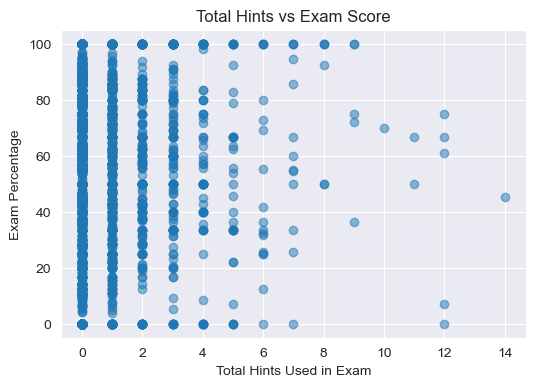

<Figure size 600x400 with 0 Axes>

/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


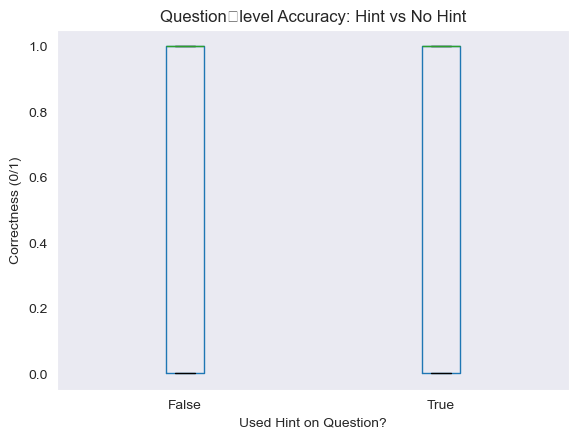

In [86]:
# 1) Merge math_results with math_questions to get tip_enabled info
# Assume math_results and math_questions are already loaded DataFrames
df = pd.merge(
    math_results,
    math_questions[['question_id', 'tip_enabled']],
    left_on='question', right_on='question_id',
    how='left'
)

# 2) Question‐level analysis by hint_count
q_stats = df.groupby('hint_count').agg(
    question_count=('question_id', 'count'),
    correct_rate=('correct', 'mean'),
    avg_points=('points', 'mean')
).reset_index()

print("Question‐level stats by hint count:")
print(q_stats)

# 3) Exam‐level hint usage and performance
# We need performances_math with columns: user_id, test_id, percentage, performance
# Assuming performances_math exists
exam_hints = df.groupby(['user_id', 'test_id']).agg(
    total_hints=('hint_count', 'sum'),
    avg_hints=('hint_count', 'mean'),
    questions_with_hints=('hint_count', lambda x: (x > 0).sum()),
    total_questions=('question_id', 'count'),
    exam_correct_rate=('correct', 'mean')
).reset_index()

exam_hints['hint_question_ratio'] = exam_hints['questions_with_hints'] / exam_hints['total_questions']

# Merge with exam performance
exam_perf = performances_math[['user_id', 'test_id', 'percentage', 'performance']]
exam_df = pd.merge(exam_hints, exam_perf, on=['user_id', 'test_id'], how='inner')

print("\nExam‐level hint usage vs performance:")
print(exam_df.head())

# 4) Correlation between hint metrics and performance
corrs = exam_df[['total_hints', 'avg_hints', 'hint_question_ratio', 'exam_correct_rate', 'percentage']].corr()
print("\nCorrelation matrix:")
print(corrs['percentage'])

# 5) Scatter plot: total hints vs percentage
plt.figure(figsize=(6,4))
plt.scatter(exam_df['total_hints'], exam_df['percentage'], alpha=0.5)
plt.xlabel('Total Hints Used in Exam')
plt.ylabel('Exam Percentage')
plt.title('Total Hints vs Exam Score')
plt.grid(True)
plt.show()

# 6) Boxplot: correctness by hint usage (question‐level)
plt.figure(figsize=(6,4))
df['used_hint'] = df['hint_count'] > 0
df.boxplot(column='correct', by='used_hint', grid=False)
plt.xlabel('Used Hint on Question?')
plt.ylabel('Correctness (0/1)')
plt.title('Question‐level Accuracy: Hint vs No Hint')
plt.suptitle('')
plt.show()

In [88]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# ————————————————
# 1) Build a “hint_group” per exam: did the student use any hints on that test?
#    We assume you already have `math_results` loaded.

# Make sure time is datetime
math_results['time'] = pd.to_datetime(math_results['time'])
# Sum hints per user_id & test_id
hint_exam = (
    math_results
    .groupby(['user_id','test_id'], as_index=False)
    .agg(total_hints=('hint_count','sum'))
)
# Binary indicator: used >=1 hint on that exam
hint_exam['hint_group'] = (hint_exam['total_hints'] > 0).astype(int)

# ————————————————
# 2) Merge that onto your exam‐level performance DataFrame
#    performances_math_features should have columns ['user_id','test_id','performance', …features…]
perf = performances_math_features.copy()
perf = perf.merge(
    hint_exam[['user_id','test_id','hint_group']],
    on=['user_id','test_id'],
    how='left'
)
# Exams with no math_results rows get NaN—treat as zero hints
perf['hint_group'] = perf['hint_group'].fillna(0).astype(int)

# ————————————————
# 3) Fit a mixed‐effects model:
#    performance ~ hint_group + (1 | user_id)
md = smf.mixedlm(
    "performance ~ hint_group",
    perf,
    groups=perf["hint_group"]    # now only 2 groups: no‐hint vs hint
)
mdf = md.fit(reml=False)
print(mdf.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: performance
No. Observations: 4440    Method:             ML         
No. Groups:       2       Scale:              705.9059   
Min. group size:  1228    Log-Likelihood:     -20868.1848
Max. group size:  3212    Converged:          No         
Mean group size:  2220.0                                 
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept      0.146   12.257  0.012 0.991 -23.878 24.169
hint_group    -0.526   17.345 -0.030 0.976 -34.521 33.469
Group Var    150.021                                     



/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimi

In [89]:
import scipy.stats as stats

grp0 = perf.loc[perf.hint_group==0, 'performance']
grp1 = perf.loc[perf.hint_group==1, 'performance']
t, p = stats.ttest_ind(grp0, grp1, equal_var=False)
print("t‐stat:", t, "p‐value:", p)

t‐stat: 0.5894494693496188 p‐value: 0.555619915047481


In [107]:
# --- 1) Compute hint_group from math_results ---
# Assumes math_results has columns ['user_id','test_id','hint_count']
hint_summary = (
    math_results
    .groupby(['user_id','test_id'], as_index=False)['hint_count']
    .sum()
    .rename(columns={'hint_count':'total_hints'})
)
hint_summary['hint_group'] = (hint_summary['total_hints'] > 0).astype(int)

# --- 2) Merge hint_group into your exam‐level features DataFrame ---
# final_df_math_drop has ['user_id','test_id', ... features ..., 'performance']
final_df_with_hints = pd.merge(
    final_df_math_drop,
    hint_summary[['user_id','test_id','hint_group']],
    on=['user_id','test_id'],
    how='left'
)
# Fill exams with no math_results rows as no‐hint
final_df_with_hints['hint_group'] = final_df_with_hints['hint_group'].fillna(0).astype(int)

# --- 3) Fit a mixed‐effects model including hint_group ---
feature_cols = [
    'recent_avg_time_per_activity',
    'days_since_last_activity',
    'total_time_spent_on_activity_before_exam',
    'average_performance_past_exams',
    'avg_activities_per_day_recent',
    'active_days_ratio_recent',
    'diversity_recent',
    'hint_group'
]

formula = 'performance ~ ' + ' + '.join(feature_cols)
md = smf.mixedlm(formula, final_df_with_hints, groups=final_df_with_hints['user_id'])
mdf = md.fit(reml=False)

print(mdf.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         performance
No. Observations:           3852            Method:                     ML         
No. Groups:                 442             Scale:                      432.1947   
Min. group size:            1               Log-Likelihood:             -17332.5057
Max. group size:            38              Converged:                  Yes        
Mean group size:            8.7                                                    
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.184    0.631  0.292 0.770 -1.052  1.421
recent_avg_time_per_activity              1.611    0.385  4.190 0.000  0.858  2.365
days_since_last

In [108]:
formula = (
    "performance ~ recent_avg_time_per_activity + days_since_last_activity + "
    "total_time_spent_on_activity_before_exam + average_performance_past_exams + "
    "avg_activities_per_day_recent + active_days_ratio_recent + diversity_recent"
)

# Build the model with hint_group as the only grouping factor:
md = smf.mixedlm(formula,
                 final_df_with_hints,
                 groups=final_df_with_hints["hint_group"],
                 re_formula="1")       # random intercept per hint_group (2 levels)
mdf = md.fit(reml=False, method='nm', maxiter=200)

print(mdf.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         performance
No. Observations:           3852            Method:                     ML         
No. Groups:                 2               Scale:                      493.1065   
Min. group size:            986             Log-Likelihood:             -17409.2791
Max. group size:            2866            Converged:                  Yes        
Mean group size:            1926.0                                                 
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.564    0.639  0.883 0.377 -0.688  1.817
recent_avg_time_per_activity              1.716    0.376  4.566 0.000  0.979  2.453
days_since_last